In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #for some plotting
import seaborn as sns #It provides a high-level interface for drawing informative statistical graphics

!pip install vaderSentiment
import nltk as nl

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

plt.style.use('ggplot')

### Section 01: Reading Dataset

In [3]:
# Read in dataset
df_tweets = pd.read_csv('/Users/jackiejabson/Desktop/TweetData_raw.csv', sep=";")

In [4]:
df_tweets.shape

(460444, 8)

In [5]:
df_tweets.head(5)

,id,text,created_at,retweet_count,reply_count,like_count,quote_count,place_id
0,1488663169744711680,"@xMBGx From what some people are saying, Sony ...",2022-02-01 23:58:52,0,0,0,0,NaN
1,1488663155479924741,Buy 50% off Silk Hydrangea Flowers #Dailydeals...,2022-02-01 23:58:48,0,0,0,0,NaN
2,1488663077142859777,i also need the gift by saturday which is the ...,2022-02-01 23:58:30,0,0,0,0,NaN
3,1488663061204373508,Bitch ass Amazon delivered my order in a clear...,2022-02-01 23:58:26,0,1,3,0,NaN
4,1488663059388407809,Redcandle's Detention is available to buy or r...,2022-02-01 23:58:26,0,0,0,0,NaN


### Section 02: Exploratory Data Analysis

In [6]:
#calculating average tweet length and word count
import numpy as np
df_tweets['text_len'] = df_tweets['text'].astype(str).apply(len)
df_tweets['text_word_count'] = df_tweets['text'].apply(lambda x: len(str(x).split()))

In [7]:
print("Average length of tweets ", round(np.mean(df_tweets['text_len'])))
print("Average word counts of tweets", round(np.mean(df_tweets['text_word_count'])))

Average length of tweets  162
Average word counts of tweets 24


<AxesSubplot:title={'center':'Histogram by the word counts of all tweets'}, ylabel='Frequency'>

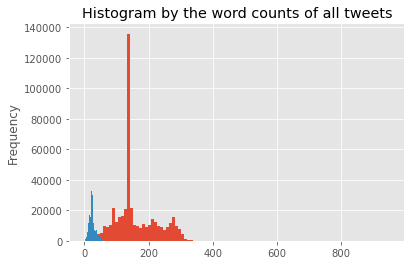

In [8]:
df_tweets['text_len'].plot(bins = 100, kind = 'hist',title = 'Histogram by length of tweets');
df_tweets['text_word_count'].plot(bins = 100, kind = 'hist', title = 'Histogram by the word counts of all tweets')

(-0.5, 399.5, 199.5, -0.5)

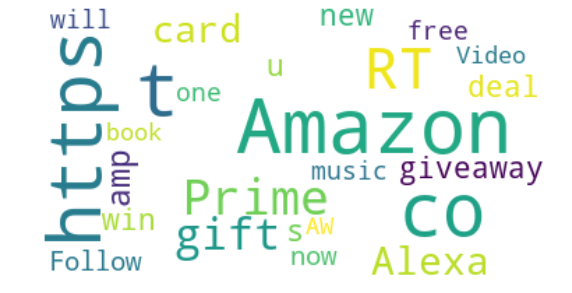

In [9]:
#Creating word cloud
from wordcloud import WordCloud, ImageColorGenerator
wc=WordCloud(collocations=False, max_font_size=55, max_words=25, background_color="white")
wc.generate(' '.join(df_tweets.text))
plt.figure(figsize=(10,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

### Section 03: Data Preprocessing

In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import re
import string


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jackiejabson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jackiejabson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def remove_duplicates(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

In [12]:
df_tweets['text'] = df_tweets['text'].apply(remove_duplicates)

In [13]:
df_tweets['text'].dropna

<bound method Series.dropna of 0         @xMBGx From what some people are saying, Sony ...
1         Buy 50% off Silk Hydrangea Flowers #Dailydeals...
2         i also need the gift by saturday which is the ...
3         Bitch ass Amazon delivered my order in a clear...
4         Redcandle's Detention is available to buy or r...
                                ...                        
460439    Netflix, Amazon prime e disney plus https://t....
460440    Free $100 Amazon Gift Card Giveaway https://t....
460441    Hey!  @alexa99 Does Not Approve of "Your Racis...
460442    @bry_farrell Hi. We're sorry to hear about the...
460443    RT @FragozoJr: @NotWoofers Forget Amazon prime...
Name: text, Length: 460444, dtype: object>

In [14]:
def clean(text):
    wn = nltk.WordNetLemmatizer() 
    stopword = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    lower = [word.lower() for word in tokens]
    no_stopwords = [word for word in lower if word not in stopword]
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    lemm_text = [wn.lemmatize(word) for word in no_alpha]
    clean_text = lemm_text
    remove_mentions = re.sub(r'(@|https?)\S+|#', '', text)
    remove_hash = remove_mentions.replace(r'#', " ")
    remove_url = re.sub(r'(?:https?|ftp):\/\/[\n\S]+/g', '', text)
    return clean_text

In [15]:
df_tweets['text'] = df_tweets['text'].apply(clean)

In [16]:
df_tweets.head(5)

,id,text,created_at,retweet_count,reply_count,like_count,quote_count,place_id,text_len,text_word_count
0,1488663169744711680,"[xmbgx, people, saying, sony, microsoft, going...",2022-02-01 23:58:52,0,0,0,0,NaN,275,48
1,1488663155479924741,"[buy, silk, hydrangea, flower, dailydeals, dis...",2022-02-01 23:58:48,0,0,0,0,NaN,151,16
2,1488663077142859777,"[also, need, gift, saturday, day, come, back, ...",2022-02-01 23:58:30,0,0,0,0,NaN,143,26
3,1488663061204373508,"[bitch, as, amazon, delivered, order, clear, p...",2022-02-01 23:58:26,0,1,3,0,NaN,88,18
4,1488663059388407809,"[redcandle, detention, available, buy, rent, a...",2022-02-01 23:58:26,0,0,0,0,NaN,87,14


### Section 03: Sentiment Analysis

In [17]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm 

In [18]:
sia = SentimentIntensityAnalyzer()

In [19]:
sentiment_tweets = df_tweets.drop(['retweet_count','reply_count', 'quote_count', 'place_id', 'like_count' ], axis = 1)

In [20]:
sentiment_tweets.head(3)

,id,text,created_at,text_len,text_word_count
0,1488663169744711680,"[xmbgx, people, saying, sony, microsoft, going...",2022-02-01 23:58:52,275,48
1,1488663155479924741,"[buy, silk, hydrangea, flower, dailydeals, dis...",2022-02-01 23:58:48,151,16
2,1488663077142859777,"[also, need, gift, saturday, day, come, back, ...",2022-02-01 23:58:30,143,26


In [21]:
def calculate_sentiment(text, category):
    try:
        # Run VADER on the text
        scores = sia.polarity_scores(" ".join(text))
        return scores.get(category)
    except:
        return "N/A"

In [22]:
def sentimentLabel(sentiment_score):
    if sentiment_score >= 0.05:
        return "Positive"
    elif sentiment_score <= -0.05: 
        return "Negative"
    else:
        return "Neutral"

In [23]:
# sentiment_tweets["negative_score"] = sentiment_tweets.apply(lambda row: 
#                                                 calculate_sentiment(row['text'], "neg"), axis = 1)
# sentiment_tweets["neutral_score"] = sentiment_tweets.apply(lambda row: 
#                                                 calculate_sentiment(row['text'], "neu"), axis = 1)
# sentiment_tweets["postive_score"] = sentiment_tweets.apply(lambda row: 
#                                                 calculate_sentiment(row['text'], "pos"), axis = 1)
sentiment_tweets["compound_score"] = sentiment_tweets.apply(lambda row: 
                                                calculate_sentiment(row['text'], "compound"), axis = 1)
sentiment_tweets["sentiment"] = sentiment_tweets.apply(lambda row:
                                                        sentimentLabel(row['compound_score']), axis = 1)

In [24]:
sentiment_tweets.head(10)

,id,text,created_at,text_len,text_word_count,compound_score,sentiment
0,1488663169744711680,"[xmbgx, people, saying, sony, microsoft, going...",2022-02-01 23:58:52,275,48,-0.3400,Negative
1,1488663155479924741,"[buy, silk, hydrangea, flower, dailydeals, dis...",2022-02-01 23:58:48,151,16,0.1779,Positive
2,1488663077142859777,"[also, need, gift, saturday, day, come, back, ...",2022-02-01 23:58:30,143,26,0.7579,Positive
3,1488663061204373508,"[bitch, as, amazon, delivered, order, clear, p...",2022-02-01 23:58:26,88,18,0.3400,Positive
4,1488663059388407809,"[redcandle, detention, available, buy, rent, a...",2022-02-01 23:58:26,87,14,0.1531,Positive
5,1488663044486008833,"[sorry, see, order, left, inappropriate, locat...",2022-02-01 23:58:22,221,31,-0.0772,Negative
6,1488663042376224772,"[rt, literaryeric, amazon, book, ranking, mean...",2022-02-01 23:58:21,140,26,0.1779,Positive
7,1488663026454695941,"[rt, jeremyclarkson, stevewoozy, bbc, netflix,...",2022-02-01 23:58:18,87,11,0.1779,Positive
8,1488662940433764352,"[thanks, like, safely, say, account, specialis...",2022-02-01 23:57:57,294,48,0.9312,Positive
9,1488662922264027138,"[yes, watched, amazon, prime, night]",2022-02-01 23:57:53,73,13,0.5267,Positive


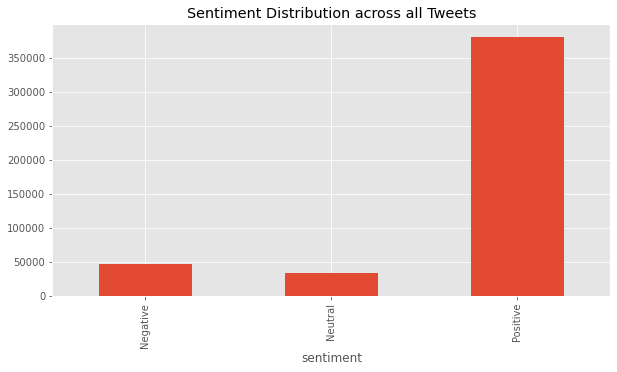

In [25]:
#Sentiment Distribution
ax = sentiment_tweets['sentiment'].value_counts().sort_index() \
    .plot(kind='bar', #type of graph
          title='Sentiment Distribution across all Tweets',
          figsize=(10, 5))
ax.set_xlabel('sentiment')
plt.show()

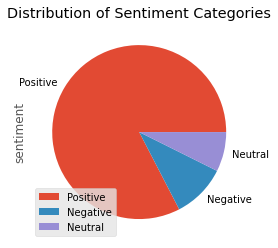

In [26]:
#plot reviews
df_pie = sentiment_tweets['sentiment'].value_counts()
df_pie.plot(kind='pie', title='Distribution of Sentiment Categories')
labels=["Positive","Negative", "Neutral"]
plt.legend(labels,loc=3)

In [27]:
sentiment_tweets.shape

(460444, 7)

### Section 04: Export File

In [ ]:
sentiment_tweets.to_csv('sentiment_twitterdata.csv')